<div style="text-align: center; color:rgb(0, 0, 0); font-family: Arial, sans-serif; background-color:rgb(137, 200, 129); padding: 10px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 1.2); line-height: 0.1;">

### **Series de Tiempo**
#### **Universidad Central**
#### Maestría en Analítica de Datos
#### Docente: Wilson Sandoval Rodriguez
##### wsandovalr@ucentral.edu.co

</div>

## Introducción 


Una serie de tiempo es una sucesión de datos ordenados cronológicamente espaciados en intervalos iguales o desiguales. El proceso de pronóstico consiste en predecir el valor futuro de una serie de tiempo, ya sea modelando la serie únicamente en función de su comportamiento pasado (autoregresivo) o utilizando otras variables externas.

![](https://www.cienciadedatos.net/images/forecasting_multi-step_en.gif)

Skforecast , una biblioteca simple que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión Scikit-learn a problemas de pronóstico.

## Aprendizaje automático para pronósticos 


Para aplicar modelos de aprendizaje automático a problemas de pronóstico, la serie de tiempo debe transformarse en una matriz en la que cada valor esté relacionado con la ventana de tiempo (retrasos) que lo precede.

En un contexto de serie de tiempo, un retraso con respecto a un paso de tiempo t
 se define como los valores de la serie en pasos de tiempo anteriores. Por ejemplo, lag 1 es el valor en el paso de tiempo $t-1$

 ![](https://www.cienciadedatos.net/images/transform_timeseries.gif)
 

Este tipo de transformación también permite incluir variables adicionales.

![](https://www.cienciadedatos.net/images/matrix_transformation_with_exog_variable.png)

Una vez que los datos se han reorganizado en la nueva forma, se puede entrenar cualquier modelo de regresión para predecir el siguiente valor (paso) de la serie. Durante el entrenamiento del modelo, cada fila se considera una instancia de datos separada, donde los valores en los retrasos $1, 2, ... p$  se consideran predictores de la cantidad objetivo de la serie de tiempo en el paso de tiempo $p+ 1$
 .

## Pronóstico recursivo de varios pasos 


Dado que el valor $t_{n-1}$  se requiere para predecir $t_n$  y $t_{n-1}$ se desconoce, se aplica un proceso recursivo en el que, cada nueva predicción, se basa en la anterior. Este proceso se conoce como pronóstico recursivo o pronóstico recursivo de varios pasos y se puede generar fácilmente con las clases `ForecasterAutoreg` y `ForecasterAutoregCustom`

![](https://www.cienciadedatos.net/images/diagram-recursive-mutistep-forecasting.png)

Diagrama recursivo del proceso de predicción de varios pasos para predecir 3 pasos hacia el futuro utilizando los últimos 4 retrasos de la serie como predictores.

## Pronóstico directo de varios pasos 
El pronóstico directo de varios pasos consiste en entrenar un modelo diferente para cada paso del horizonte de pronóstico. Por ejemplo, para predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos diferentes, uno para cada paso. Como resultado, las predicciones son independientes entre sí

![](https://www.cienciadedatos.net/images/diagram-direct-multi-step-forecasting.png)

Diagrama directo del proceso de predicción de varios pasos para predecir 3 pasos hacia el futuro utilizando los últimos 4 retrasos de la serie como predictores.

La principal complejidad de este enfoque es generar las matrices de entrenamiento correctas para cada modelo. La clase `ForecasterAutoregDirect` de la biblioteca `skforecast` automatiza este proceso. También es importante tener en cuenta que esta estrategia tiene un mayor costo computacional ya que requiere el tren de múltiples modelos. El siguiente diagrama muestra el proceso para un caso en el que se dispone de la variable de respuesta y dos variables exógenas.

![](https://www.cienciadedatos.net/images/diagram_skforecast_multioutput.png)

## Pronóstico autorregresivo recursivo 


 Se pretende crear un modelo autorregresivo capaz de predecir valores futuros

Bibliotecas 


Las bibliotecas utilizadas en este documento son:

In [4]:
#%pip install skforecast==0.12.1

In [5]:
import skforecast
print(skforecast.__version__)


0.12.1


In [6]:
import skforecast
import os
print(os.listdir(skforecast.__path__[0]))

['datasets', 'exceptions', 'ForecasterAutoreg', 'ForecasterAutoregCustom', 'ForecasterAutoregDirect', 'ForecasterAutoregMultiSeries', 'ForecasterAutoregMultiSeriesCustom', 'ForecasterAutoregMultiVariate', 'ForecasterBase', 'ForecasterBaseline', 'ForecasterRnn', 'ForecasterSarimax', 'model_selection', 'model_selection_multiseries', 'model_selection_sarimax', 'plot', 'preprocessing', 'Sarimax', 'utils', '__init__.py', '__pycache__']


In [7]:

# ==============================================================================
import numpy as np
import pandas as pd


# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline


# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from xgboost import XGBRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings

# warnings.filterwarnings('ignore')

In [9]:
data=pd.read_excel("https://github.com/Wilsonsr/Series-de-Tiempo/raw/main/Data/Desempleo.xlsx")
data

,Año-Mes (AAAA-MM),Tasa de ocupación (%),Tasa de desempleo (%)
0,2001-01,57.575200,16.622300
1,2001-02,56.928200,17.434200
2,2001-03,57.574500,15.811900
3,2001-04,55.756700,14.515100
4,2001-05,56.225800,14.035800
...,...,...,...
279,2024-04,57.157354,10.646716
280,2024-05,57.502190,10.305871
281,2024-06,57.160909,10.268590
282,2024-07,57.802120,9.918145


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Año-Mes (AAAA-MM)      284 non-null    object 
 1   Tasa de ocupación (%)  284 non-null    float64
 2   Tasa de desempleo (%)  284 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.8+ KB


In [11]:
from ydata_profiling import ProfileReport

visions.backends INFO  Pandas backend loaded 2.2.2
visions.backends INFO  Numpy backend loaded 1.26.4
visions.backends INFO  Pyspark backend loaded 3.5.5
visions.backends INFO  Python backend loaded


In [12]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
data.columns

Index(['Año-Mes (AAAA-MM)', 'Tasa de ocupación (%)', 'Tasa de desempleo (%)'], dtype='object')

In [15]:
data = data.rename(columns={'Año-Mes (AAAA-MM)': 'date'})
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.rename(columns={'Tasa de desempleo (%)': "Desempleo"})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,Tasa de ocupación (%),Desempleo
date,,
2001-01-01,57.5752,16.6223
2001-02-01,56.9282,17.4342
2001-03-01,57.5745,15.8119
2001-04-01,55.7567,14.5151
2001-05-01,56.2258,14.0358


In [16]:
print(f'Número de Filas con valores nulos: {data.isnull().any(axis=1).mean()}')


Número de Filas con valores nulos: 0.0


In [17]:
# Verifique que un índice temporal esté completo 
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()


True

In [18]:
#Train_test split# ==============================================================================
steps = 12
data_train = data[:-steps]
data_test  = data[-steps:]


In [19]:

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Train dates : 2001-01-01 00:00:00 --- 2023-08-01 00:00:00  (n=272)
Test dates  : 2023-09-01 00:00:00 --- 2024-08-01 00:00:00  (n=12)


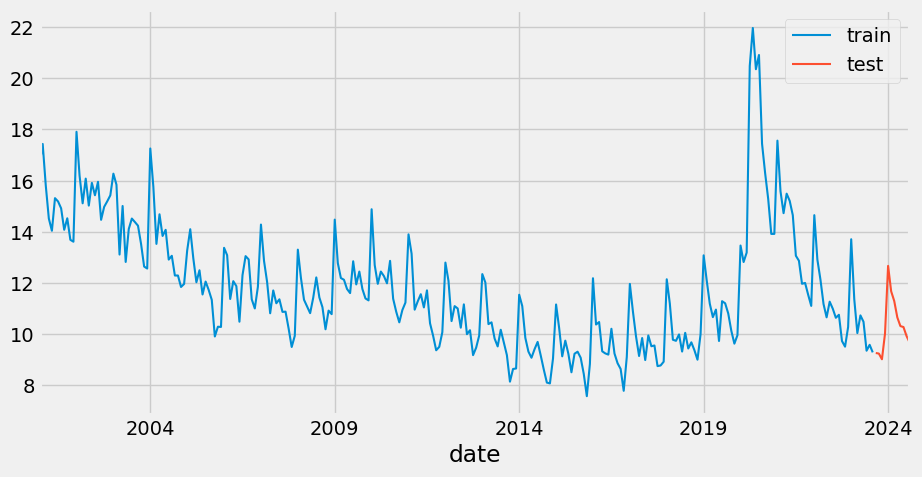

In [20]:

fig, ax = plt.subplots(figsize=(10, 5))
data_train['Desempleo'].plot(ax=ax, label='train')
data_test['Desempleo'].plot(ax=ax, label='test')
ax.legend();

## Pronosticador Autoreg 


Con la clases `ForecasterAutoreg` se crea y entrena un modelo a partir de un `RandomForestRegressorregresor` con una ventana de tiempo de 12 rezagos. Esto significa que el modelo utiliza los 12 meses anteriores como predictores.

In [48]:
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = 12
             )

forecaster.fit(y=data_train['Desempleo'])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous v

## Predicciones 


Una vez que se entrena el modelo, se predicen los datos de prueba (36 meses en el futuro).

In [49]:
steps = 12
predictions = forecaster.predict(steps=steps)
predictions

2023-09-01     9.076050
2023-10-01     8.993563
2023-11-01     9.119792
2023-12-01     9.913180
2024-01-01    12.633747
2024-02-01    12.008429
2024-03-01    10.665119
2024-04-01    11.001263
2024-05-01    10.562718
2024-06-01    10.490964
2024-07-01    10.759003
2024-08-01    10.185315
Freq: MS, Name: pred, dtype: float64

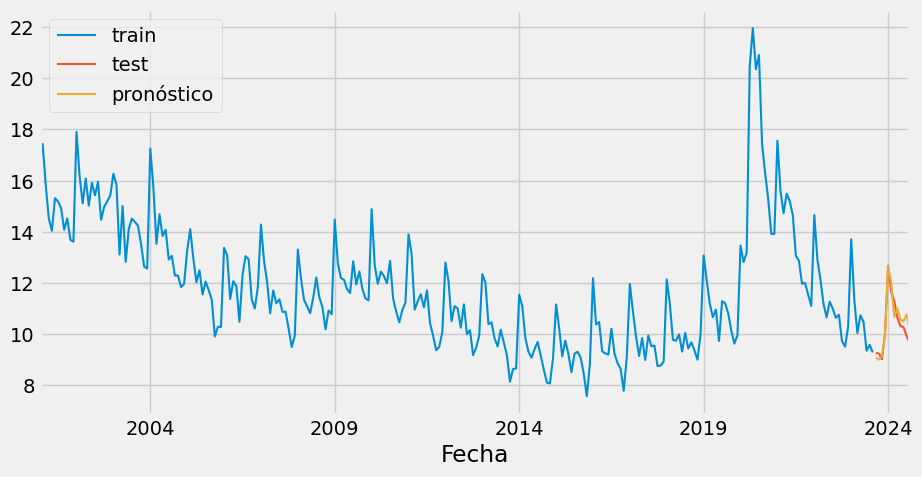

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
data_train['Desempleo'].plot(ax=ax, label='train')
data_test['Desempleo'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='pronóstico')
plt.xlabel('Fecha')
ax.legend();

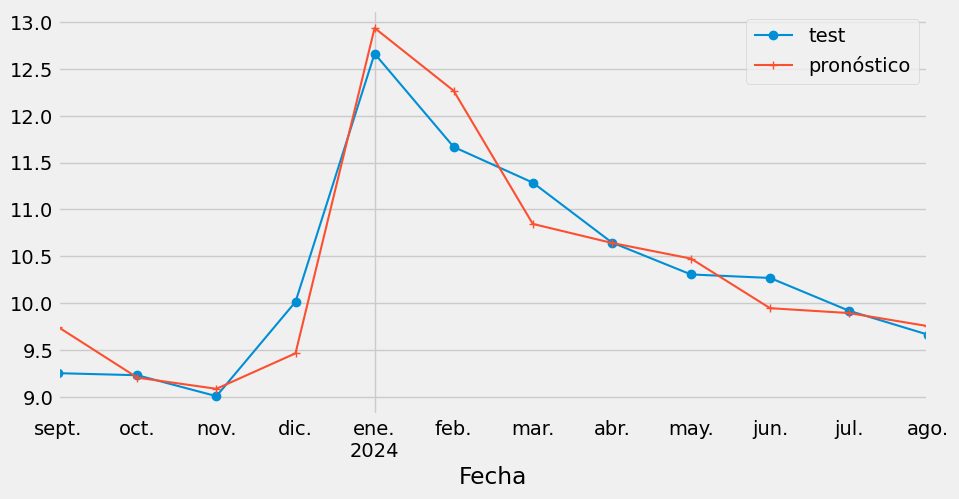

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
#data_train['Desempleo'].plot(ax=ax, label='train')
data_test['Desempleo'].plot(ax=ax, label='test', marker='o')
predictions.plot(ax=ax, label='pronóstico', marker='+')
plt.xlabel('Fecha')
ax.legend();

## Error de predicción en el conjunto Test


Se cuantifica el error que comete el modelo en sus predicciones. En este caso, la métrica utilizada es el error cuadrático medio (mse).

# MSE

In [29]:
error_mse = mean_squared_error(
                y_true = data_test['Desempleo'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.11000198478306601


## RMSE

In [30]:
error_rmse = root_mean_squared_error(
                y_true = data_test['Desempleo'],
                y_pred = predictions
            )

print(f"Test error (Rmse): {error_rmse}")

Test error (Rmse): 0.3316654711950974


In [70]:
np.sqrt(0.004038053499192591)

0.06354568041332621

## MAPE

In [31]:
error_MAPE = mean_absolute_percentage_error(
                y_true = data_test['Desempleo'],
                y_pred = predictions
            )

print(f"Test error (MAPE): {error_MAPE}")

Test error (MAPE): 0.024306661041824013


## Ajuste de hiperparámetros 


El entrenamiento `ForecasterAutoreg` usa una ventana de tiempo de retraso de 6 y un modelo Random Forest con los hiperparámetros predeterminados. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. Para identificar la mejor combinación de retrasos e hiperparámetros, la biblioteca Skforecast proporciona la función `grid_search_forecaster`. Compara los resultados obtenidos con cada configuración del modelo.

In [32]:
#Hyperparameter Grid search
# ==============================================================================
steps = 12
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 
             )

# Lags used as predictors
lags_grid = [6,12, 18,24]

# Regressor's hiperparametros
param_grid = {'max_depth': [3, 5, 10], 
              'min_samples_split': [2, 5, 10],
              'n_estimators': [50, 100, 200]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Desempleo'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(data_train)*0.8),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 108.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/27 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}
  Backtesting metric: 0.1882982504556727



In [33]:
# Grid Search results
# ==============================================================================
results_grid

,lags,lags_label,params,mean_absolute_percentage_error,max_depth,min_samples_split,n_estimators
18,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.188298,10,2,50
21,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.191892,10,5,50
20,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.192630,10,2,200
24,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'min_samples_split': 10, 'n_...",0.194128,10,10,50
23,"[1, 2, 3, 4, 5, 6]","[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.194649,10,5,200
...,...,...,...,...,...,...,...
40,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.303267,5,5,100
39,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'min_samples_split': 5, 'n_es...",0.304534,5,5,50
37,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'min_samples_split': 2, 'n_es...",0.305148,5,2,100
36,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'min_samples_split': 2, 'n_es...",0.305294,5,2,50


## Modelo final 


Finalmente, `ForecasterAutoreg` se entrena a con la configuración óptima encontrada por validación. 

In [34]:
regressor = RandomForestRegressor(max_depth=10, n_estimators=50, min_samples_split=2, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 12
             )

forecaster.fit(y=data_train['Desempleo'])

In [35]:
pronostico = forecaster.predict(steps=steps)

In [36]:
pronostico

2023-09-01     9.824710
2023-10-01     9.274740
2023-11-01     9.308348
2023-12-01     9.513558
2024-01-01    12.964659
2024-02-01    12.208657
2024-03-01    10.843190
2024-04-01    10.726400
2024-05-01    10.593468
2024-06-01    10.242363
2024-07-01    10.033876
2024-08-01     9.774245
Freq: MS, Name: pred, dtype: float64

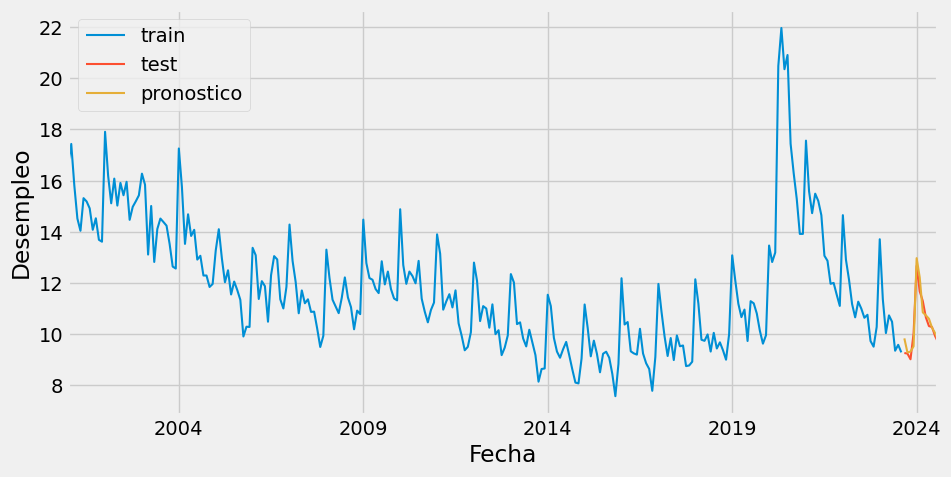

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
data_train['Desempleo'].plot(ax=ax, label='train')
data_test['Desempleo'].plot(ax=ax, label='test')
pronostico.plot(ax=ax, label='pronostico')
plt.xlabel('Fecha')
plt.ylabel('Desempleo')
ax.legend();

In [38]:
#error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['Desempleo'],
                y_pred = pronostico
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 0.11395433799026004


In [39]:
root_mean_squared_error(y_true= data_test['Desempleo'],
                         y_pred = pronostico)

0.33757123394960664

In [40]:
mean_absolute_percentage_error(y_true=data_test['Desempleo'], y_pred=pronostico)

0.026728370204961518

In [31]:
pronostico

2023-09-01     9.906856
2023-10-01     9.350311
2023-11-01     9.347403
2023-12-01     9.490487
2024-01-01    12.578388
2024-02-01    12.103069
2024-03-01    10.714357
2024-04-01    10.732707
2024-05-01    10.556608
2024-06-01    10.022472
2024-07-01     9.412243
2024-08-01     9.343171
Freq: MS, Name: pred, dtype: float64

In [41]:
# Reentrenar el modelo con todos los datos disponibles
forecaster.fit(y=data['Desempleo'])


In [42]:
# Definir número de pasos a predecir
future_steps = 12

# Hacer el pronóstico
forecast_full = forecaster.predict(steps=future_steps)

# Ver resultados
print(forecast_full)


2024-09-01     9.437165
2024-10-01     9.209902
2024-11-01     9.081863
2024-12-01     9.514677
2025-01-01    11.563535
2025-02-01    11.768775
2025-03-01    11.656905
2025-04-01    10.742001
2025-05-01    10.355417
2025-06-01    10.021097
2025-07-01     9.707044
2025-08-01     9.685553
Freq: MS, Name: pred, dtype: float64


Text(0.5, 1.0, 'Pronóstico de Desempleo - Modelo Random Forest')

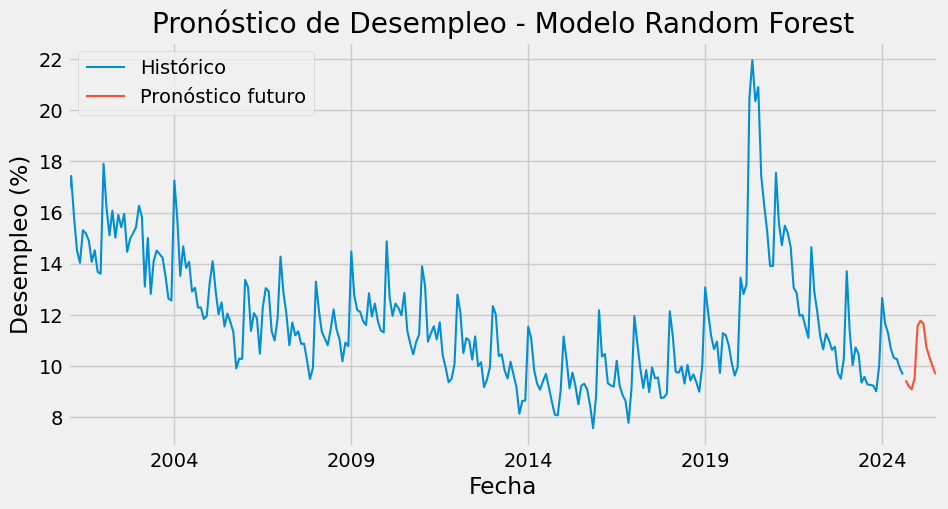

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
data['Desempleo'].plot(ax=ax, label='Histórico')
forecast_full.plot(ax=ax, label='Pronóstico futuro')
plt.xlabel('Fecha')
plt.ylabel('Desempleo (%)')
ax.legend()
plt.title('Pronóstico de Desempleo - Modelo Random Forest')
